In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39835")
client

<Client: 'tcp://127.0.0.1:39835' processes=10 threads=50, memory=196.70 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
chaos = '/tank/chaocean/tuchida/'
# savedir = '/tank/chaocean/tuchida/ECycle/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100
zchunk = 4

nmembs = np.arange(100,148)

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).chunk({'YC':ychunk,'YG':ychunk,
                              'XC':xchunk,'XG':xchunk})
grid = Grid(dsg, periodic=['X'])
Vol = (dsg.hFacC * dsg.rA * dsg.drF).where(dsg.maskC!=0.)
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic, boundary=None):
  * center   time

In [38]:
for itime in ntimes[yystart,:1]: 
    
    ds0m = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                           grid_dir=gdir,
                           prefix=['snap_diagOcn'], delta_t=2e2,
                           iters=itime, 
                          ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
    ds1m = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                           grid_dir=gdir,
                           prefix=['diagUm'], delta_t=2e2,
                           iters=itime, ignore_unknown_vars=True
                          ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
    ds2m = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                           grid_dir=gdir,
                           prefix=['diagVm'], delta_t=2e2,
                           iters=itime, ignore_unknown_vars=True
                          ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
    Um_dEdxm = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagUm'), 
                                           itrs=itime, rec=3,    # Vertical dissipation
                                     # usememmap=True
                                          ),
                            dims=ds0m.UVEL.dims, coords=ds0m.UVEL.coords
                           ).chunk({'Z':zchunk,'YC':ychunk,'XG':xchunk}) 
    Vm_dEdym = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagVm'), 
                                           itrs=itime, rec=3,    # Vertical dissipation
                                     # usememmap=True
                                          ),
                            dims=ds0m.VVEL.dims, coords=ds0m.VVEL.coords
                           ).chunk({'Z':zchunk,'YG':ychunk,'XC':xchunk})
    Um_Disvm = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagUm'), 
                                           itrs=itime, rec=5,    # Vertical dissipation
                                     # usememmap=True
                                          ),
                            dims=ds0m.UVEL.dims, coords=ds0m.UVEL.coords
                           ).chunk({'Z':zchunk,'YC':ychunk,'XG':xchunk}) 
    Vm_Disvm = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagVm'), 
                                           itrs=itime, rec=5,    # Vertical dissipation
                                     # usememmap=True
                                          ),
                            dims=ds0m.VVEL.dims, coords=ds0m.VVEL.coords
                           ).chunk({'Z':zchunk,'YG':ychunk,'XC':xchunk})
    
    tend  = (grid.interp(ds0m.UVEL * ds1m.TOTUTEND,'X') 
             + grid.interp(ds0m.VVEL * ds2m.TOTVTEND,
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.)
    advec = (grid.interp(ds0m.UVEL * ds1m.Um_Advec,'X') 
             + grid.interp(ds0m.VVEL * ds2m.Vm_Advec,
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.)
    pwrk  = (grid.interp(ds0m.UVEL * (Um_dEdxm + ds1m.Um_dPHdx),
                         'X') 
             + grid.interp(ds0m.VVEL * (Vm_dEdym + ds2m.Vm_dPHdy),
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.)
    forc  = (grid.interp(ds0m.UVEL * ds1m.Um_Ext,'X') 
             + grid.interp(ds0m.VVEL * ds2m.Vm_Ext,
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.).isel(Z=0)
    diss  = (grid.interp(ds0m.UVEL * (ds1m.Um_Diss + Um_Disvm),'X') 
             + grid.interp(ds0m.VVEL * (ds2m.Vm_Diss + Vm_Disvm),
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.)
    ab    = (grid.interp(ds0m.UVEL * ds1m.AB_gU,'X') 
             + grid.interp(ds0m.VVEL * ds2m.AB_gV,
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.)
    
    dsave = tend.to_dataset(name='TEND')
    dsave['ADVEC'] = advec
    dsave['PRES'] = pwrk
    dsave['FORC'] = forc
    dsave['DISS'] = diss
    dsave['ADAM'] = ab
    dsave.to_zarr(op.join(savedir,'%4d/%010d/Mean/MKE_bud.zarr' 
                          % (years[yystart],itime)), mode='w')
        
    ds0m.close()
    ds1m.close()
    ds2m.close()

    print(itime)

1419120


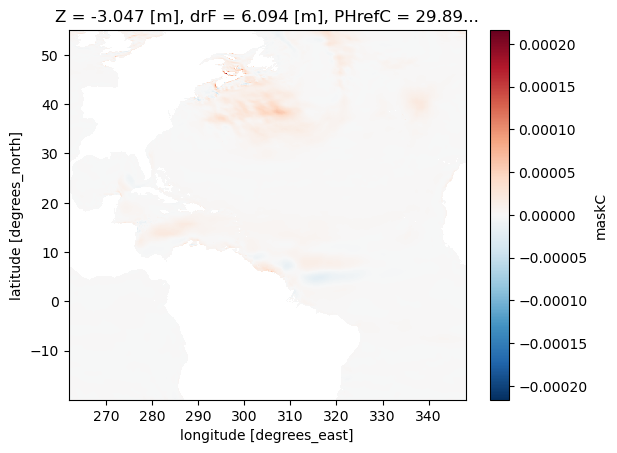

In [11]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
for itime in ntimes[yystart]:
    dsm = xr.open_zarr(op.join(savedir,'%4d/%010d/Mean/MKE_bud.zarr' 
                                  % (years[yystart],itime))
                         )
    if itime == ntimes[yystart,0]:
        dsM = dsm
        forc = xr.zeros_like(dsg.maskC) * np.nan
        forc[dict(Z=0)] = dsm.FORC
        FORC = forc
        FORC.isel(Z=0).plot()
        plt.show()
    else:
        dsM = xr.concat([dsM, dsm], 'time')
        forc = xr.zeros_like(dsg.maskC) * np.nan
        forc[dict(Z=0)] = dsm.FORC
        FORC = xr.concat([FORC, forc], 'time')
    dsm.close()
    del forc
    # print(itime)
        
dsave = ((dsM.PRES*Vol).sel(
                           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                           # XC=slice(xmin,xmax)
                          ).sum(['Z','YC','XC'],skipna=True)
         / Vol.sel(
                   # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                   # XC=slice(xmin,xmax)
                  ).sum(['Z','YC','XC'],skipna=True)
        ).reset_coords(drop=True).chunk({'time':-1}).to_dataset(name='PRES')
dsave['TEND'] = ((dsM.TEND*Vol).sel(
                                   # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                                   # XC=slice(xmin,xmax)
                                  ).sum(['Z','YC','XC'],skipna=True)
                 / Vol.sel(
                           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                           # XC=slice(xmin,xmax)
                          ).sum(['Z','YC','XC'],skipna=True)
                ).reset_coords(drop=True).chunk({'time':-1})
dsave['DISS'] = ((dsM.DISS*Vol).sel(
                                   # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                                   # XC=slice(xmin,xmax)
                                  ).sum(['Z','YC','XC'],skipna=True)
                 / Vol.sel(
                           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                           # XC=slice(xmin,xmax)
                          ).sum(['Z','YC','XC'],skipna=True)
                ).reset_coords(drop=True).chunk({'time':-1})
dsave['ADAM'] = ((dsM.ADAM*Vol).sel(
                                   # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                                   # XC=slice(xmin,xmax)
                                  ).sum(['Z','YC','XC'],skipna=True)
                 / Vol.sel(
                           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                           # XC=slice(xmin,xmax)
                          ).sum(['Z','YC','XC'],skipna=True)
                ).reset_coords(drop=True).chunk({'time':-1})
dsave['FORC'] = ((FORC*Vol).where(dsg.maskC!=0.).sel(
                               # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                               # XC=slice(xmin,xmax)
                              ).sum(['Z','YC','XC'],skipna=True)
                 / Vol.sel(
                           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
                           # XC=slice(xmin,xmax)
                          ).sum(['Z','YC','XC'],skipna=True)
                ).reset_coords(drop=True).chunk({'time':-1})
dsave.to_zarr(op.join(savedir,
                      # '%4d/Mean/MKEbud_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                      # % (years[yystart],ymin,ymax,xmin,xmax)
                      '%4d/Mean/MKEbud_VolAve.zarr' 
                      % (years[yystart])
                     ), mode='w')

In [7]:
dsM = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                           'XC':xchunk,'XG':xchunk})
grid = Grid(dsM, periodic=['X'])

dsm = xr.open_zarr(op.join(savedir,'%4d/%010d/Mean/MKE_bud.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsk = xr.open_zarr(op.join(savedir,'%4d/%010d/K-k.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dss = xr.open_zarr(op.join(savedir,'%4d/%010d/S-P.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
# dsA = xr.open_zarr(op.join(savedir,'%4d/%010d/Mean/Advect.zarr' 
#                            % (years[yystart],ntimes[0,0]))
#                   )
dsA = xr.open_zarr(op.join(savedir,'%4d/%010d/Mean/Advect_precise.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsAKE = xr.open_zarr(op.join(savedir,'%4d/%010d/Mean/Advect_explicit.zarr' 
                             % (years[yystart],ntimes[0,0]))
                    )
dsa = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Advect.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsb = xr.open_zarr(op.join(savedir,'%04d/ensm/%010d/BUOY.zarr' 
                               % (years[0],ntimes[0,0]))
                      )

In [9]:
for itime in ntimes[yystart,:1]:
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds0 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                          % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['snap_diagOcn'], delta_t=2e2,
                                  iters=itime, 
                                 ).isel(time=0
                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                          % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagUm'], delta_t=2e2,
                                  iters=itime, ignore_unknown_vars=True
                                 ).isel(time=0
                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
            ds2 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                          % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagVm'], delta_t=2e2,
                                  iters=itime, ignore_unknown_vars=True
                                 ).isel(time=0
                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk}) 
        else:
            ds0 = xr.concat([ds0, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                          % (nmemb)), 
                                                  grid_dir=gdir,
                                                  prefix=['snap_diagOcn'], delta_t=2e2,
                                                  iters=itime, 
                                                 ).isel(time=0
                                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                                'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')   
            ds1 = xr.concat([ds1, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                          % (nmemb)), 
                                                  grid_dir=gdir,
                                                  prefix=['diagUm'], delta_t=2e2,
                                                  iters=itime, ignore_unknown_vars=True
                                                 ).isel(time=0
                                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                                'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')
            ds2 = xr.concat([ds2, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                          % (nmemb)), 
                                                  grid_dir=gdir,
                                                  prefix=['diagVm'], delta_t=2e2,
                                                  iters=itime, ignore_unknown_vars=True
                                                 ).isel(time=0
                                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                                'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb') 

    ds0.coords['nmemb'] = ('nmemb',nmembs)
    ds1.coords['nmemb'] = ('nmemb',nmembs)
    ds2.coords['nmemb'] = ('nmemb',nmembs)
    print(itime)

1419120


In [10]:
Gtu = (ds0.UVEL * ds1.Um_Advec
      ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()
Gtv = (ds0.VVEL * ds2.Vm_Advec
      ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()

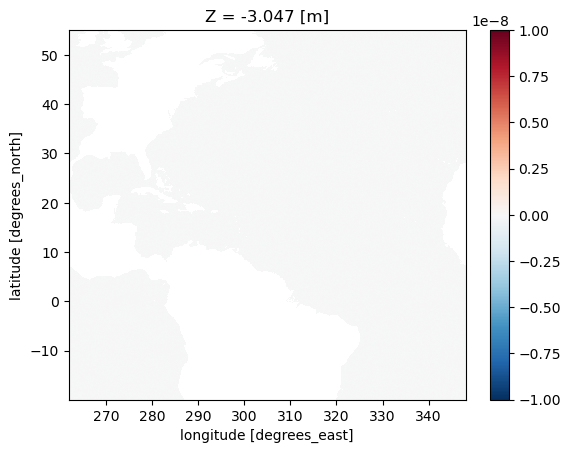

In [23]:
(((grid.interp(Gtu,'X') 
   - (dsA.Um_Advec + grid.interp(dsa.Um_Advec,'X'))
  ) + (grid.interp(Gtv,'Y',boundary='extend') 
       - (dsA.Vm_Advec + grid.interp(dsa.Vm_Advec,'Y',boundary='extend'))
      )
 ) + dsk.Kk
).isel(Z=0).plot(vmax=1e-8, rasterized=True)

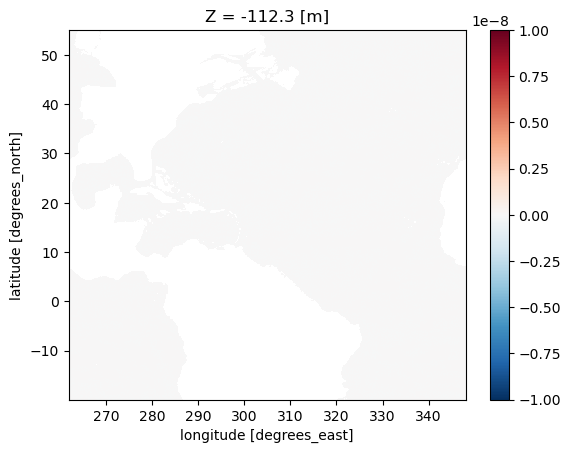

In [24]:
((dsA.Um_Advec + dsA.Vm_Advec - dsk.Kk)
 - (grid.interp(Gtu - dsa.Um_Advec,'X') 
    + grid.interp(Gtv - dsa.Vm_Advec,'Y',boundary='extend')
   ).reset_coords(drop=True)
).isel(Z=10).plot(vmax=1e-8, rasterized=True)

In [36]:
rhs0 = (dsm.PRES + dsm.DISS + dsm.ADAM
        + ((grid.interp(Gtu - dsa.Um_Advec,'X') 
            + grid.interp(Gtv - dsa.Vm_Advec,'Y',boundary='extend')
           ).reset_coords(drop=True)
           # + dsk.Kk - dsk.Kk
          )
       )
rhs0[dict(Z=0)] += dsm.FORC
rhs0

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<setitem, shape=(46, 900, 1000), dtype=float64, chunksize=(4, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>

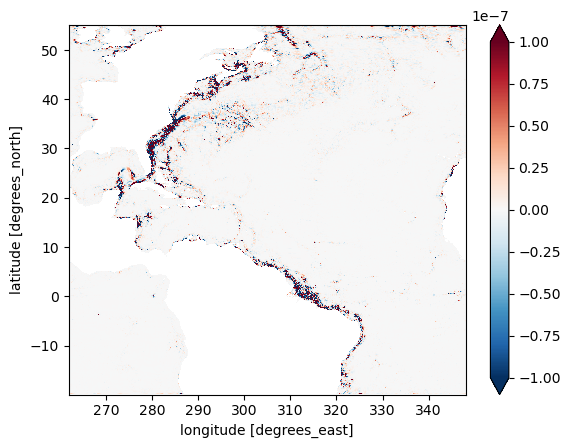

In [33]:
((((dsA.Um_Advec + dsA.Vm_Advec) - dsAKE.KE_Advec) * dsg.drF
 ).sum('Z',skipna=True) / 1e3).where(dsg.maskInC!=0.).plot(vmax=1e-7)

In [40]:
RHS = (dsm.ADVEC + dsm.PRES + dsm.DISS + dsm.ADAM)
RHS[dict(Z=0)] += dsm.FORC

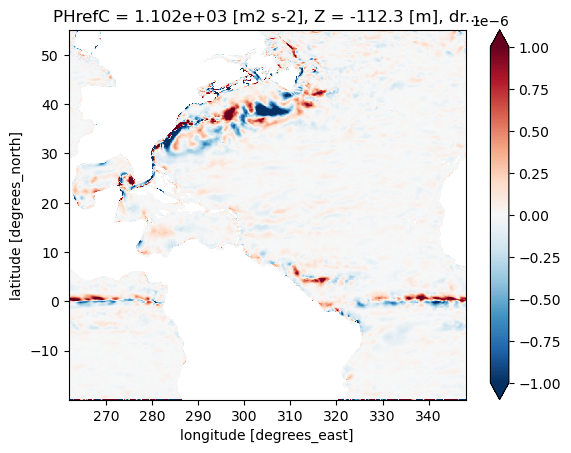

In [23]:
rhs1 = (dsm.PRES + dsm.DISS + dsm.ADAM
        + (dsA.Um_Advec + dsA.Vm_Advec)
        - dsk.Kk 
       )
rhs2 = (dsm.PRES + dsm.DISS + dsm.ADAM
        # + (dsA.Um_Advec + dsA.Vm_Advec)
        + dsAKE.KE_Advec
        - dsk.Kk 
       )
rhs1[dict(Z=0)] += dsm.FORC
rhs2[dict(Z=0)] += dsm.FORC
rhs1.isel(Z=10).plot(vmax=1e-6)

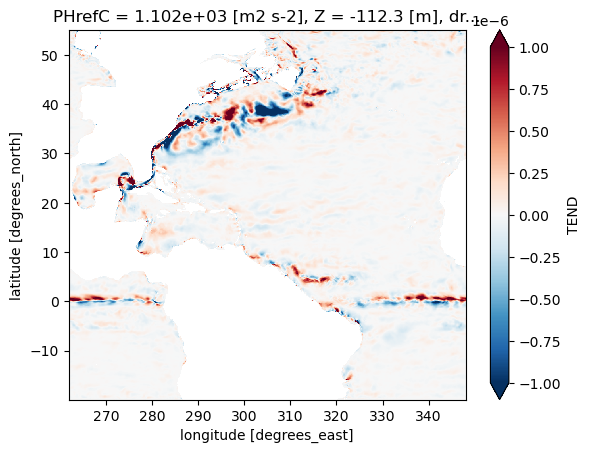

In [14]:
(dsm.TEND/86400).isel(Z=10).plot(vmax=1e-6)

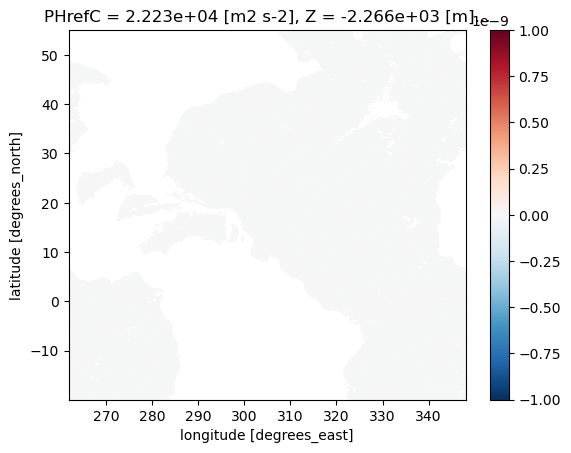

In [40]:
(rhs0 - rhs1).isel(Z=30).plot(vmax=1e-9, rasterized=True)

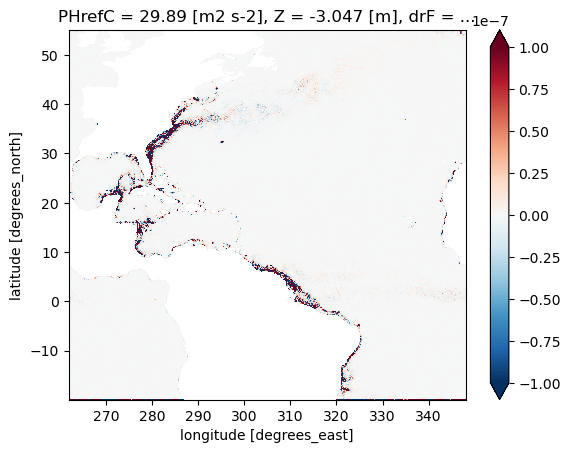

In [37]:
(dsm.TEND/86400 - rhs0
 - dsk.Kk
).isel(Z=10).plot(vmax=1e-6)

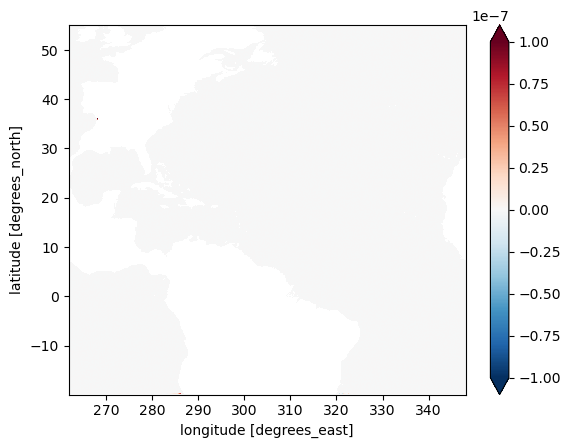

In [41]:
(((-dsm.TEND/86400 
   + RHS
  ) * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
 / 1e3).where(dsg.maskInC!=0.).plot(vmax=1e-7)

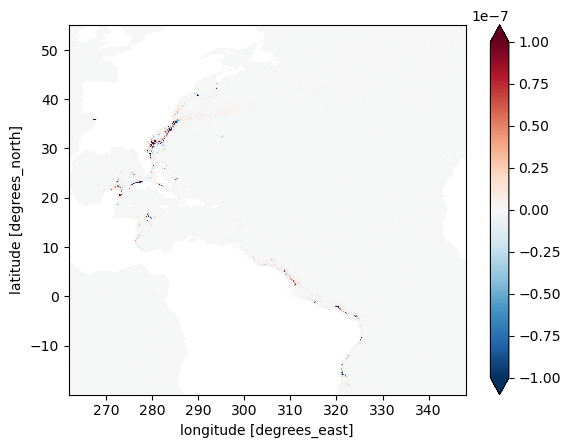

In [46]:
(((dsm.ADVEC - (dsA.Um_Advec + dsA.Vm_Advec))
  * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
 / 1e3).where(dsg.maskInC!=0.).plot(vmax=1e-7)

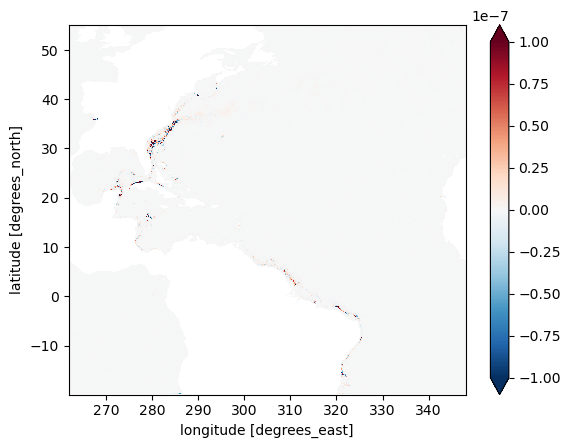

In [31]:
(((dsm.TEND/86400 - rhs1
   - dsk.Kk
  ) * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
 / 1e3).where(dsg.maskInC!=0.).plot(vmax=1e-7)

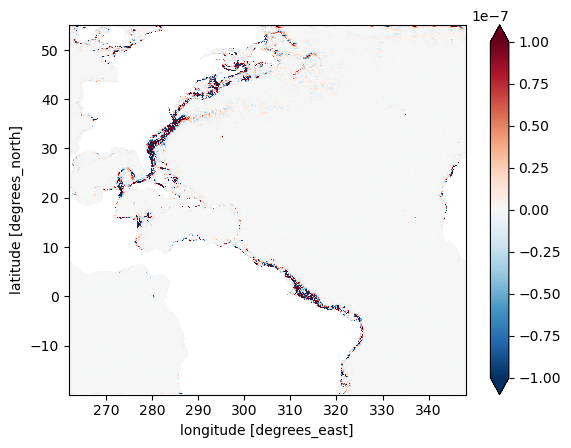

In [30]:
(((dsm.TEND/86400 - rhs2
   - dsk.Kk
  ) * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
 / 1e3).where(dsg.maskInC!=0.).plot(vmax=1e-7)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,15))

im = axes[0,0].pcolormesh(dsm.XC, dsm.YC, 
                          (((dsm.TEND/86400-dsk.Kk)
                            * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                           /1e3),
                     cmap='PiYG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)
axes[0,1].pcolormesh(dsm.XC, dsm.YC, 
                     # (rhs*dsg.drF
                     # ).reset_coords(drop=True).sel(Z=slice(None,-1e3)
                     #                              ).sum('Z',skipna=True)/1e3,
                     ((grid.interp(dsM.WVEL,'Z',boundary='extend')
                       * dsb.BUOY.where(dsm.maskC!=0.)
                      )*dsg.drF
                     ).reset_coords(drop=True).sel(Z=slice(None,-1e3)
                                                  ).sum('Z',skipna=True)/1e3*1e-3,
                     cmap='PiYG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)

axes[1,0].pcolormesh(dsm.XC, dsm.YC, 
                     (dsm.PRES*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='PiYG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)
axes[1,1].pcolormesh(dsm.XC, dsm.YC, dsm.FORC*1e-2,
                     cmap='PiYG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)

axes[2,0].pcolormesh(dsm.XC, dsm.YC, 
                     ((grid.interp(dsA.Um_Advec,'X') 
                       + grid.interp(dsA.Vm_Advec,'Y',boundary='extend'))
                      * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='PiYG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)
axes[2,1].pcolormesh(dsm.XC, dsm.YC, 
                     -(dsk.Kk*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='PiYG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)
# axes[2,1].pcolormesh(dsm.XC, dsm.YC, 
#                      (dss.ShProd*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
#                      cmap='bwr', vmax=1e-7, vmin=-1e-7,
#                      rasterized=True)

axes[0,0].set_title(r"$K^\#_t$", fontsize=14)
axes[0,1].set_title(r"$\langle w\rangle\overline{b}\, (\times 10^{-3})$", 
                    fontsize=14)
axes[1,0].set_title(r"$-\langle u\rangle\cdot\nabla_{\tt h}\langle\phi\rangle$", 
                    fontsize=14)
axes[1,1].set_title(r"$\langle u\rangle\cdot\langle\mathcal{F}\rangle\, (\times 10^{-2})$", 
                    fontsize=14)
axes[2,0].set_title(r"$-\langle v\rangle\cdot\nabla K^\#$", fontsize=14)
axes[2,1].set_title(r"$-(\langle u\rangle\nabla\cdot\langle v'u'\rangle$" 
                    + r"$+ \langle v\rangle\nabla\cdot\langle v'v'\rangle)$", 
                    fontsize=14)
# axes[2,1].set_title(r"$\langle v'u'\rangle\cdot\nabla\langle u\rangle$", fontsize=14)

axes[0,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)

fig.subplots_adjust(right=.86, wspace=.115, hspace=.06) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[(m$^{2}\,$s$^{-2})\, /\, s$]", fontsize=12)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_xlabel('Longitude', fontsize=12)
axes[2,1].set_xlabel('Longitude', fontsize=12)

plt.savefig(op.join(savedir,'Figures/MKE_aveZ1000budget_%010d.pdf' % ntimes[0,0]))

In [16]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
dsE = xr.open_zarr(op.join(savedir,
                           '%4d/MKE_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsM = xr.open_zarr(op.join(savedir,
                           '%4d/Mean/MKEbud_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dswb = xr.open_zarr(op.join(savedir,
                            '%4d/WB_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                            % (years[0],ymin,ymax,xmin,xmax)
                           ))
dsk = xr.open_zarr(op.join(savedir,
                           '%4d/K-k_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
# dss = xr.open_zarr(op.join(savedir,'%4d/S-P_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
#                            % (years[0],ymin,ymax,xmin,xmax)))
dsA = xr.open_zarr(op.join(savedir,
                           '%4d/MKEADV-precise_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsA

<xarray.Dataset>
Dimensions:  (time: 73)
Dimensions without coordinates: time
Data variables:
    advec    (time) float32 dask.array<chunksize=(73,), meta=np.ndarray>

In [14]:
from datetime import timedelta
time = np.arange('1967-01-01', '1968-01-01', timedelta(days=5), dtype='datetime64[D]')
time

array(['1967-01-01', '1967-01-06', '1967-01-11', '1967-01-16',
       '1967-01-21', '1967-01-26', '1967-01-31', '1967-02-05',
       '1967-02-10', '1967-02-15', '1967-02-20', '1967-02-25',
       '1967-03-02', '1967-03-07', '1967-03-12', '1967-03-17',
       '1967-03-22', '1967-03-27', '1967-04-01', '1967-04-06',
       '1967-04-11', '1967-04-16', '1967-04-21', '1967-04-26',
       '1967-05-01', '1967-05-06', '1967-05-11', '1967-05-16',
       '1967-05-21', '1967-05-26', '1967-05-31', '1967-06-05',
       '1967-06-10', '1967-06-15', '1967-06-20', '1967-06-25',
       '1967-06-30', '1967-07-05', '1967-07-10', '1967-07-15',
       '1967-07-20', '1967-07-25', '1967-07-30', '1967-08-04',
       '1967-08-09', '1967-08-14', '1967-08-19', '1967-08-24',
       '1967-08-29', '1967-09-03', '1967-09-08', '1967-09-13',
       '1967-09-18', '1967-09-23', '1967-09-28', '1967-10-03',
       '1967-10-08', '1967-10-13', '1967-10-18', '1967-10-23',
       '1967-10-28', '1967-11-02', '1967-11-07', '1967-

In [15]:
rhs0 = ((dsM.PRES 
         # - dsb.wb   
        ) 
        + dsA.advec
        - dsk.Kk 
        + dsM.DISS
        + dsM.ADAM
        + dsM.FORC
       )
rhs0

<xarray.DataArray (time: 73)>
dask.array<add, shape=(73,), dtype=float64, chunksize=(73,), chunktype=numpy.ndarray>
Dimensions without coordinates: time

Text(0, 0.5, 'Terms in MKE budget')

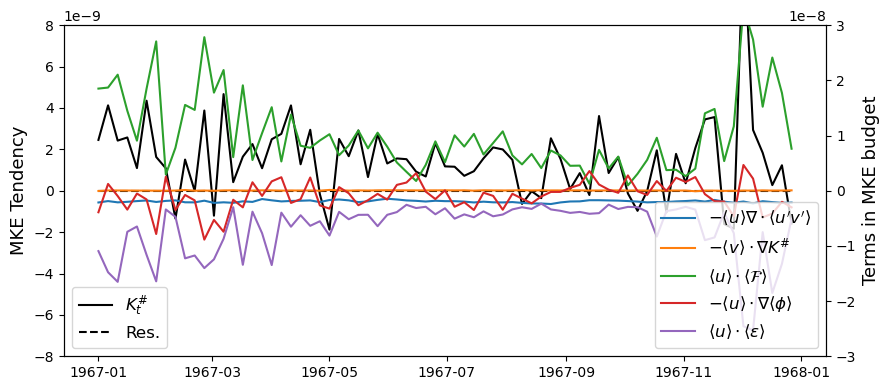

In [17]:
fig, ax = plt.subplots(figsize=(9,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, dsM.TEND/86400-dsk.Kk, 'k', label=r"$K^\#_t$")
ax.plot(time, (dsM.TEND/86400-dsk.Kk - rhs0), 'k--', label=r"Res.")

ax2.plot(time, -dsk.Kk, label=r"$-\langle u\rangle\nabla\cdot\langle u'v'\rangle$")
# ax2.plot(time, dswb.WB, label=r"$\langle w\rangle\langle b\rangle$")
ax2.plot(time, dsA.advec, label=r"$-\langle v\rangle\cdot\nabla K^\#$")
ax2.plot(time, dsM.FORC, label=r"$\langle u\rangle\cdot \langle\mathcal{F}\rangle$")
ax2.plot(time, dsM.PRES, label=r"$-\langle u\rangle\cdot\nabla\langle\phi\rangle$")
# ax2.plot(time, dsM.PRES-dswb.WB, label=r"$-\langle v\rangle\cdot\nabla\langle\phi\rangle$")
ax2.plot(time, dsM.DISS, label=r"$\langle u\rangle\cdot\langle\epsilon\rangle$")

ax.set_ylim([-.8e-8,.8e-8])
# ax2.set_ylim([-1e-6,1e-6])
ax2.set_ylim([-3e-8,3e-8])

ax.legend(loc='lower left', fontsize=12)
ax2.legend(loc='lower right', fontsize=12)

ax.set_ylabel(r"MKE Tendency", fontsize=13)
ax2.set_ylabel(r"Terms in MKE budget", fontsize=13)